# 11 폐렴을 진단해보자


의료 인공지능은 다양한 분야에서 사용됩니다. 질병의 정확한 분류 또는 환자의 중증도를 확인하는 용도 등 다양한 용도로 사용됩니다.

이 중에서 현재 가장 핫한 분야는 질병을 탐지해내는 인공지능입니다. 이제 우리는 의사처럼 질병을 찾아내는 딥러닝 모델을 만들어보려고 합니다.

우리가 할 것은 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것입니다. 폐렴에 대해서 전혀 모르신다고요? 아래에 쉽게 이해할 수 있도록 설명 해놓았으니 너무 걱정 마세요~



#### 데이터셋

이번 노드에서 사용할 데이터는 캐글의 Chest X-Ray Images 입니다.

데이터의 구성은 ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.

(에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 중복된 데이터는 필요하지 않습니다.

해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다. 


#### 폐렴이란?

우리가 데이터를 직접 분석하기 전에 폐렴에 대해서 알아야겠죠? 폐렴은 무엇일까요? 요즘.. 코로나 때문에 폐렴에 대한 지식을 어느 정도 가졌을 것으로 생각됩니다.

폐렴은 쉽게 말해 폐에 염증이 생기는 것입니다. 일단 폐는 여러분들도 너무 잘 아시는 것과 같이 공기를 들이마셔 호흡 작용을 하는 기관이겠죠? 그럼 염증은 정확히 무엇일까요?

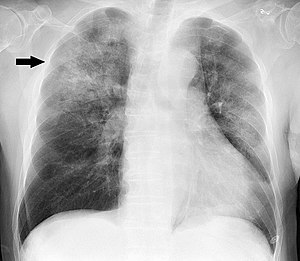

폐렴의 구별법은 언뜻 예상외로 간단합니다.
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됩니다.
구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵습니다.


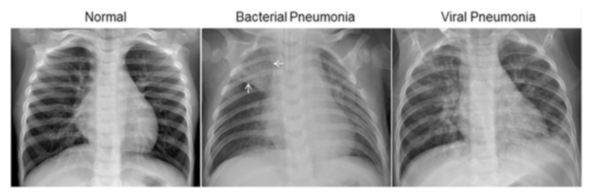


정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줍니다.
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타납니다.

위와 같이 폐렴에 걸린 사진들은 특징이 패턴을 이루고 있는 것을 볼 수 있습니다.
이런 패턴을 잘 읽어내는 딥러닝 알고리즘은 충분히 학습 시킬 수 있을 것 같죠?
딥러닝 알고리즘들이 패턴인식 알고리즘의 일종이라고 부르는 것처럼,
이 이미지에서 폐렴의 특징 패턴을 학습해서 찾아내게 시키면 됩니다.

그럼 이제 폐렴인지 아닌지에 대해 진단을 내릴 수 있는 딥러닝 모델을 만들어 봅시다.

(참고) 아래 제공되는 실습코드는 이 캐글 노트북(https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)
을 기반으로 작성된 것임을 밝힙니다.


## 1. Set-up

가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.

우리가 이번 프로젝트에서 사용할 패키지 목록입니다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')



import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Input, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation, Resizing
from tensorflow.keras.optimizers import Adam

In [38]:
# 앞으로 필요한 변수들을 생성합니다.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [528, 528]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/EXP_11_Pneumonia_CNN/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/EXP_11_Pneumonia_CNN/data/val/*/*'
TEST_PATH = ROOT_PATH + '/EXP_11_Pneumonia_CNN/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 50

print(ROOT_PATH)
print(TRAIN_PATH)
print(VAL_PATH)
print(TEST_PATH)

/aiffel/aiffel
/aiffel/aiffel/EXP_11_Pneumonia_CNN/data/train/*/*
/aiffel/aiffel/EXP_11_Pneumonia_CNN/data/val/*/*
/aiffel/aiffel/EXP_11_Pneumonia_CNN/data/test/*/*


## 2. 데이터 가져오기

import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

In [39]:

# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드를 활용한다.
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 별 개수 확인
print('train 데이터의 개수는', len(train_filenames), '개 입니다')
print('test 데이터의 개수는', len(test_filenames), '개 입니다')
print('val 데이터의 개수는', len(val_filenames), '개 입니다')

train 데이터의 개수는 5216 개 입니다
test 데이터의 개수는 624 개 입니다
val 데이터의 개수는 16 개 입니다


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [40]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('재조정된 train 데이터의 개수는', len(train_filenames), '개 입니다')
print('재조정된 val 데이터의 개수는', len(val_filenames), '개 입니다')

재조정된 train 데이터의 개수는 4185 개 입니다
재조정된 val 데이터의 개수는 1047 개 입니다


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

In [41]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데, 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/EXP_11_Pneumonia_CNN/data/train/NORMAL/NORMAL2-IM-0634-0001.jpeg
Pneumonia image path
/aiffel/aiffel/EXP_11_Pneumonia_CNN/data/train/PNEUMONIA/person630_bacteria_2513.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

In [42]:

# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [43]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [44]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [45]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [46]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [47]:
train = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)

val = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)


이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [48]:
for image, label in train.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (528, 528, 3)
Label:  False


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요! 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.

위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [49]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size=1000)

test = test.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [50]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train = prepare_for_training(train)
val = prepare_for_training(val)

## 데이터 시각화

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

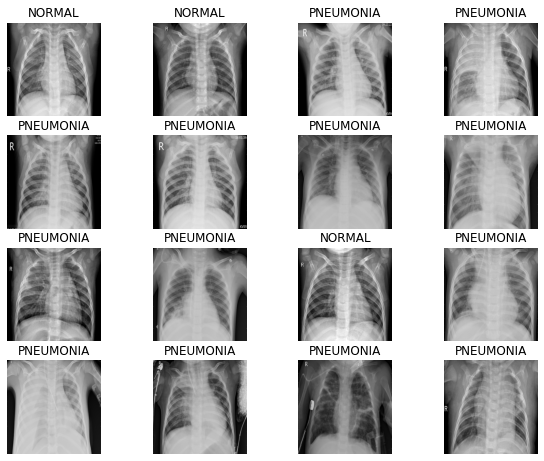

In [51]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.

CNN, Convolutional Neural Network 요약 (http://taewan.kim/post/cnn/)

먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [52]:
"""
이미지를 Augmentation 해주는 레이어를 만들어줍니다. 모델을 만들 때 augmentation layer을 넣으면 자동으로 이미지를 다양하게 변환하여 줍니다.
더 많은 augmentation을 적용해보고 싶으면 https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing 이 링크를 참조하세요.
또한, imgaug, albumentation과 같은 강력한 augmentation 라이브러리도 살펴보세요. 
"""
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.10), #이미지를 좌우로 10% 이내로 랜덤으로 돌립니다. 
        layers.experimental.preprocessing.RandomZoom((-0.01, 0)), #이미지를 0~10%만큼 랜덤으로 축소합니다.
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)

In [56]:
from PIL import Image

#read the image
im = Image.open(ROOT_PATH + '/EXP_11_Pneumonia_CNN/data/train/NORMAL/IM-0115-0001.jpeg')
im01 = Image.open(ROOT_PATH + '/EXP_11_Pneumonia_CNN/data/train/NORMAL/IM-0117-0001.jpeg')


#image size
print(im.size)
print(im01.size)

(2090, 1858)
(1422, 1152)


In [71]:
"""
이 베이스라인에서는 transfer learning을 사용합니다. 미리 훈련되어 있는 이미지용 모델을 불러와서 그 모델의 뒤쪽에 나만의 모델을 추가한 뒤 학습하는 방식입니다.
직접 수많은 레이어의 모델을 디자인하는 것은 어렵기 때문에 이러한 방법을 사용합니다.
여기서는 구글의 EfficientNetB2 사용합니다. 이 모델에 대한 자세한 내용은 https://arxiv.org/pdf/1905.11946.pdf 이 논문을 참고하세요.

주의!! imagenet 가중치 값을 다운받기 위하여 우측 상단 |< 표시를 누르고 setting에서 Internet을 켜줘야합니다.
"""

from tensorflow.keras.applications import EfficientNetB1
dropout_rate = 0.2 #드롭아웃 비율 정의
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

print(input_shape)

efficientnet = EfficientNetB1(weights="imagenet", #이미지넷 가중치 값을 불러와 적용
                              include_top=False, 
                              input_shape=input_shape, 
                              drop_connect_rate=dropout_rate) #efficientnetB0 모델을 로드
efficientnet.trainable=False # efficientnetb0의 학습을 허용. 만약 False로 지정할 시에 정확도는 떨어지지만 학습 속도가 매우 빨라짐.

(528, 528, 3)


In [72]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [73]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [74]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0,
    #patience는 "무조건 이 iteration까지는 해 보자"해서 그 iteration 횟수를 정의
    mode='auto', baseline=None, restore_best_weights=True
)

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift
위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks
이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [84]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        
        data_augmentation_layers,
        efficientnet,
        
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

딥러닝에서 클래스 불균형을 다루는 방법
아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.



In [85]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

**Early stopping을 넣어줍니다!**

In [86]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [88]:
with tf.device('/GPU:0'):
    history = model.fit(
        train,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        callbacks=early_stopping,
        epochs=EPOCHS,
        validation_data=val,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 587s 757ms/step - loss: 0.9246 - accuracy: 0.5151 - precision: 0.7585 - recall: 0.5158 - val_loss: 0.6290 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 193s 742ms/step - loss: 0.7911 - accuracy: 0.4905 - precision: 0.7440 - recall: 0.4866 - val_loss: 0.5818 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 196s 751ms/step - loss: 0.7485 - accuracy: 0.4943 - precision: 0.7489 - recall: 0.4851 - val_loss: 0.7228 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
261/261 [==============================] - 192s 738ms/step - loss: 0.7311 - accuracy: 0.5085 - precision: 0.7511 - recall: 0.5074 - val_loss: 0.6330 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 5/50
261/261 [==============================] - 188s 719ms/step - loss: 0.

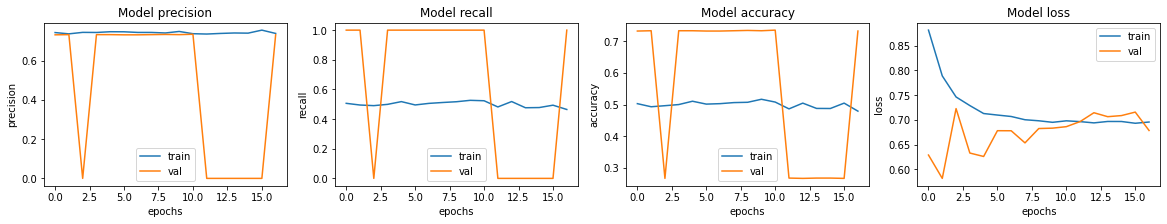

In [89]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [91]:
loss, accuracy, precision, recall = model.evaluate(test)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 26s 495ms/step - loss: 0.6758 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6757532954216003,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [93]:
loss, accuracy, precision, recall = model.evaluate(test)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 26s 500ms/step - loss: 0.6758 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6757532954216003,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
